# Upper Animas PEST Pilot Point Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config
import matplotlib.pyplot as plt


In [2]:
from apexmf import apexmf_pst_utils

In [3]:

# sys.path.insert(0, 'D:/spark-brc_gits/apexmf_git/apexmf_pkgs')
# # from apexmf_pst_pkgs import apexmf_pst_utils, apexmf_pst_par
# import apexmf_pst_utils

In [4]:
wd = "d:/Projects/Watersheds/Animas/Analysis/AMRSs/manul_calibration/ies_template_pp/"
pstfile = "animas_amrs_pp.pst"
os.chdir(wd)

# MODFLOW parameters with Pilot Points

In [5]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) #<-- load only prevents reading ibound
mname = 'modflow.nam'
m = flopy.modflow.Modflow.load(mname,
            model_ws=wd
            )
m.check()

Errors and/or Warnings encountered.
Errors and/or Warnings encountered.

modflow MODEL DATA VALIDATION SUMMARY:
  163 Warnings:
    GHB package: BC in inactive cell
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS
    RIV package: BC in inactive cell
    UPW package: specific yield values above checker threshold of 0.5

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: vertical hydraulic conductivity values below checker threshold of 1e-11
    UPW package: vertical hydrauli

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(wd, "modflow.nam"),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

   could not remove start_datetime


In [ ]:
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
prefix_dict = {0:["sy0"]}
df_pp_hk = pyemu.pp_utils.setup_pilotpoints_grid(ml=m,
                                              prefix_dict=prefix_dict,
                                              pp_dir=wd,
                                              tpl_dir=wd,
                                              every_n_cell=10,
                                              shapename='pp_sy.shp')

In [8]:
# change shapefile and file name
shpwd = wd
shp = 'pp_sy.shp'
shp_changed = 'sy0pp.shp'
ppf = shp_changed[:-3] + 'dat'
ppf

'sy0pp.dat'

In [9]:
shpwd = os.path.join(wd, "MODFLOW")

In [57]:
#read file, parse out the records and shapes
shapefile_path = os.path.join(shpwd, shp)
sf = shapefile.Reader(shapefile_path)

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
shapefile_dataframe = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
shapefile_dataframe = shapefile_dataframe.assign(coords=shps)

pp_df = shapefile_dataframe.sort_values(by=['name'])
print(pp_df)

       name        x         y  zone  parval1  k    i   j              tpl   
0   pp_0000  65500.0  125500.0   1.0      1.0  0    5  65  ~    sy000    ~  \
1   pp_0001  55500.0  115500.0   1.0      1.0  0   15  55  ~    sy001    ~   
2   pp_0002  65500.0  115500.0   1.0      1.0  0   15  65  ~    sy002    ~   
3   pp_0003  35500.0  105500.0   1.0      1.0  0   25  35  ~    sy003    ~   
4   pp_0004  45500.0  105500.0   1.0      1.0  0   25  45  ~    sy004    ~   
5   pp_0005  55500.0  105500.0   1.0      1.0  0   25  55  ~    sy005    ~   
6   pp_0006  65500.0  105500.0   1.0      1.0  0   25  65  ~    sy006    ~   
7   pp_0007  35500.0   95500.0   1.0      1.0  0   35  35  ~    sy007    ~   
8   pp_0008  45500.0   95500.0   1.0      1.0  0   35  45  ~    sy008    ~   
9   pp_0009  55500.0   95500.0   1.0      1.0  0   35  55  ~    sy009    ~   
10  pp_0010  65500.0   95500.0   1.0      1.0  0   35  65  ~    sy010    ~   
11  pp_0011  35500.0   85500.0   1.0      1.0  0   45  35  ~    

- get list of salt ion
- change tpl name for new par name
- write dataframe to pp.dat file
- write tpl file for pp.dat file


In [58]:
sions_ = ["SO4", "Ca", "Mg", "Na", "K", "Cl", "CO3", "HCO3"]
sions = [i.lower() for i in sions_] 
sions

['so4', 'ca', 'mg', 'na', 'k', 'cl', 'co3', 'hco3']

In [ ]:
f"salt_{ionnam}0pp.dat"

In [69]:
sionsf = [f"salt_{i.lower()}0pp.dat.ref" for i in sions_] 

In [70]:
sionsf

['salt_so40pp.dat.ref',
 'salt_ca0pp.dat.ref',
 'salt_mg0pp.dat.ref',
 'salt_na0pp.dat.ref',
 'salt_k0pp.dat.ref',
 'salt_cl0pp.dat.ref',
 'salt_co30pp.dat.ref',
 'salt_hco30pp.dat.ref']

In [59]:
conts = [744.43, 216.34, 29.38, 1199.12, 3.39, 1379.27, 16.61, 1853.8]


In [60]:
for ionnam, cont in zip(sions, conts):
    df = pp_df.copy()
    # write dataframe to pp.dat file
    new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')
    pyemu.utils.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat", new_df) # create dat
    pp_to_tpl(new_df, f"salt_{ionnam}0pp.dat") # create tpl
    intp_krigging(cont, 15000, new_df, ionnam)

starting interp point loop for 9956 points
took 35.401976 seconds
starting interp point loop for 9956 points
took 34.964389 seconds
starting interp point loop for 9956 points
took 35.578679 seconds
starting interp point loop for 9956 points
took 35.038868 seconds
starting interp point loop for 9956 points
took 35.088808 seconds
starting interp point loop for 9956 points
took 34.927859 seconds
starting interp point loop for 9956 points
took 34.892979 seconds
starting interp point loop for 9956 points
took 34.997797 seconds


In [14]:
def change_tpl_name(tpl_df, newnam, oldnam='sy'):
    tpl_df['tpl'] = tpl_df['tpl'].str.replace(oldnam, newnam)
    tpl_df['pargp'] = tpl_df['pargp'].str.replace(oldnam, newnam)
    tpl_df['parnme'] = tpl_df['parnme'].str.replace(oldnam, newnam)
    return tpl_df

In [15]:
PP_FMT = {"name": SFMT, "x": FFMT, "y": FFMT, "zone": IFMT, "tpl": SFMT,
          "parval1": FFMT}
def pp_to_tpl(new_df, pp_file, tpl_file=None):
    names = new_df['parnme'].tolist() # for hk
    # names = new_df['sypar'].tolist() # for sy  
#     names = new_df['parnme'].tolist() # for river conductance      
    if tpl_file is None:
        tpl_file = pp_file + ".tpl"    
    tpl_entries = ["~    {0}    ~".format(name) for name in names]
    new_df.loc[:,"tpl"] = tpl_entries
    new_df.loc[:,"parnme"] = names


    f_tpl = open(tpl_file,'w')
    f_tpl.write("ptf ~\n")
    f_tpl.write(new_df.to_string(col_space=0,
                              columns=["name","x","y","zone","tpl"],
                              formatters=PP_FMT,
                              justify="left",
                              header=False,
                              index=False) + '\n')    


In [56]:
def intp_krigging(cont, a, new_df, ionnam):
    v = pyemu.geostats.ExpVario(contribution=cont,a=a, bearing=0)
    gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0)
    ok = pyemu.geostats.OrdinaryKrige(gs,new_df)
    df = ok.calc_factors_grid(sr,
    #                           var_filename=pst_name.replace(".pst",".var.ref"),
                              var_filename= f"salt_{ionnam}0pp." + "var.ref",                          
                              minpts_interp=1,maxpts_interp=50,
                              search_radius=5000000000000.0)
    ok.to_grid_factors_file(f"salt_{ionnam}0pp.dat"+".fac")

In [52]:
pyemu.geostats.ExpVario

In [61]:
ionnam = "so4"

In [62]:
df = pp_df.copy()
# write dataframe to pp.dat file
new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')

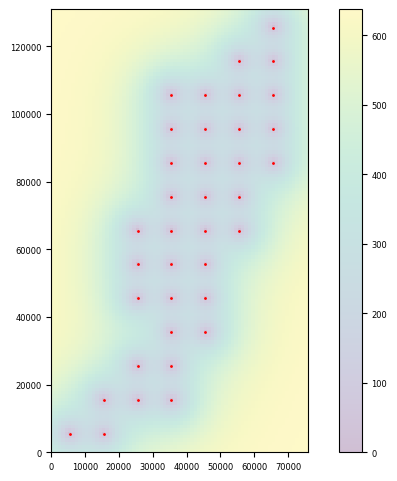

In [63]:
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(f"salt_{ionnam}0pp." + "var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=sr.get_extent(),alpha=0.25)
plt.colorbar(p)
plt.tight_layout()
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='r')

In [64]:
# generate random values
new_df.loc[:,"parval1"] = np.random.random(new_df.shape[0])
# save a pilot points file
pyemu.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat",new_df)

In [65]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.utils.geostats.fac2real(f"salt_{ionnam}0pp.dat",factors_file=f"salt_{ionnam}0pp.dat"+".fac",out_file=None)

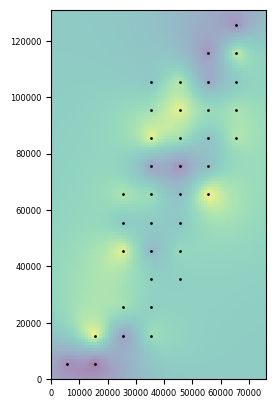

In [66]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=sr.get_extent(),alpha=0.5)
ax.scatter(new_df.x,new_df.y,marker='.',s=4,color='k')

# Create instruction file for observed depth to water

In [2]:
wd = "D:/Projects/Watersheds/Animas/Analysis/APEX-MODFLOWs/calibrations/v03"
os.chdir(wd)

In [3]:
mf_obs = pd.read_csv(
                    "MODFLOW/modflow.obs",
                    delim_whitespace=True,
                    skiprows = 2,
                    usecols = [3, 4],
                    index_col = 0,
                    names = ["grid_id", "mf_elev"],)
grid_ids = mf_obs.index.tolist()

In [4]:
grid_ids = [5895, 6273]

In [5]:
apexmf_pst_utils.extract_depth_to_water(grid_ids, '1/1/1987', '10/30/2003')

dtw_5895.txt file has been created...
dtw_6273.txt file has been created...
Finished ...


In [35]:
mfobd_file = 'dtw_day.obd'

In [36]:
mfobd_df = pd.read_csv(
                    "MODFLOW/" + mfobd_file,
                    sep='\s+',
                    index_col=0,
                    header=0,
                    parse_dates=True,
                    na_values=[-999, ""],
                    delimiter="\t")

In [39]:
# Change depth to water to absolute values
absmfobd_df = mfobd_df.abs()
absmfobd_df.to_csv('dtw_day.obd', sep='\t', na_rep=-999, float_format='%.2f')


In [7]:
apexmf_pst_utils.mf_obd_to_ins('dtw_6273.txt', 'gw_098', '1/1/1987', '10/30/2003')

dtw_6273.txt.ins file has been created...


In [4]:
os.getcwd()

'D:\\Projects\\Watersheds\\Animas\\Analysis\\APEX-MODFLOWs\\calibrations\\v03'

# Create instruction file for streamflow /sediment

In [5]:
# file path
rch_file = 'SITE75.RCH'
# reach numbers that are used for calibration
subs = [12, 57, 72, 75]

In [6]:
# extract month_streamflow
apexmf_pst_utils.extract_month_str(rch_file, subs, '1/1/1987', '1/1/1992', '12/31/2011')
apexmf_pst_utils.extract_month_sed(rch_file, subs, '1/1/1987', '1/1/1992', '12/31/2011')

cha_012.txt file has been created...
cha_057.txt file has been created...
cha_072.txt file has been created...
cha_075.txt file has been created...
Finished ...
sed_012.txt file has been created...
sed_057.txt file has been created...
sed_072.txt file has been created...
sed_075.txt file has been created...
Finished ...


In [8]:
# because we have 3 streamgages let's loop for them
# read streamobd and get column names
stf_obd = pd.read_csv(
                    'stf_mon.obd',
                    sep='\t',
                    index_col=0,
                    parse_dates=True,
                    na_values=[-999, '']
                    )
# stf_obd_c = stf_obd.resample('M').mean()
# stf_obd_c.to_csv('streamflow_m.obd', sep='\t', na_rep=-999, float_format='%.2f')
obds = stf_obd.columns.tolist()
# obds.remove('str_072')
# obds.remove('sed_072')
print(obds)
sim_files = ['stf_{:03d}.txt'.format(x) for x in subs]
sed_files = ['sed_{:03d}.txt'.format(x) for x in subs]
sim_files = sim_files + sed_files
print(sim_files)

['str_012', 'str_057', 'str_072', 'str_075', 'sed_012', 'sed_057', 'sed_072', 'sed_075']
['stf_012.txt', 'stf_057.txt', 'stf_072.txt', 'stf_075.txt', 'sed_012.txt', 'sed_057.txt', 'sed_072.txt', 'sed_075.txt']


In [9]:
# create instruction files for each sim file
for i in range(len(sim_files)):
    apexmf_pst_utils.stf_obd_to_ins(sim_files[i], obds[i], '1/1/1992', '12/31/2011', time_step='month')

stf_012.txt.ins file has been created...
stf_057.txt.ins file has been created...
stf_072.txt.ins file has been created...
stf_075.txt.ins file has been created...
sed_012.txt.ins file has been created...
sed_057.txt.ins file has been created...
sed_072.txt.ins file has been created...
sed_075.txt.ins file has been created...


In [ ]:
mfwd = "D:/Projects/Watersheds/Animas/Analysis/APEX-MODFLOWs/calibrations/v02/MODFLOW"
rivf = 'mf_1000.riv'
apexmf_pst_utils.fix_riv_pkg(mfwd, rivf)

In [14]:
import apexmf_pst_par

In [22]:
# provide channel ids that will be used for calibration
subs = ['rg01', 'rg02', 'rg03', 'rg04', 'rg05']
apexmf_pst_par.create_riv_par(mfwd, subs)

'mf_riv.par' file has been exported to the MODFLOW working directory!


,parnme,chg_type,val
parnme,,,
rivcd_rg01,rivcd_rg01,unfchg,0.001
rivcd_rg02,rivcd_rg02,unfchg,0.001
rivcd_rg03,rivcd_rg03,unfchg,0.001
rivcd_rg04,rivcd_rg04,unfchg,0.001
rivcd_rg05,rivcd_rg05,unfchg,0.001
rivbot_rg01,rivbot_rg01,unfchg,0.001
rivbot_rg02,rivbot_rg02,unfchg,0.001
rivbot_rg03,rivbot_rg03,unfchg,0.001
rivbot_rg04,rivbot_rg04,unfchg,0.001


In [25]:
# create a template file for mf_riv.par file
apexmf_pst_utils.riv_par_to_template_file('mf_riv.par')

,parnme,chg_type,parval1,tpl
parnme,,,,
rivcd_rg01,rivcd_rg01,pctchg,0.001,~ rivcd_rg01 ~
rivcd_rg02,rivcd_rg02,pctchg,0.001,~ rivcd_rg02 ~
rivcd_rg03,rivcd_rg03,pctchg,0.001,~ rivcd_rg03 ~
rivcd_rg04,rivcd_rg04,pctchg,0.001,~ rivcd_rg04 ~
rivcd_rg05,rivcd_rg05,pctchg,0.001,~ rivcd_rg05 ~
rivbot_rg01,rivbot_rg01,unfchg,0.001,~ rivbot_rg01 ~
rivbot_rg02,rivbot_rg02,unfchg,0.001,~ rivbot_rg02 ~
rivbot_rg03,rivbot_rg03,unfchg,0.001,~ rivbot_rg03 ~
rivbot_rg04,rivbot_rg04,unfchg,0.001,~ rivbot_rg04 ~


In [26]:
# overwrite the river package file
apexmf_pst_par.riv_par(mfwd)

The "riv_package.org" file already exists...
mf_1000.riv file is overwritten successfully!


In [31]:
os.chdir(wd)

In [33]:
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)
pyemu.helpers.pst_from_io_files(io_files[0], io_files[1], io_files[2], io_files[3], 'ani_dummy.pst')

# print(os.chdir(".."))
io_files

C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file dtw_5895.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file dtw_5895.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file dtw_6273.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file dtw_6273.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file sed_012.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file sed_012.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file sed_057.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file sed_057.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file sed_072.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file sed_072.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))
C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file sed_075.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file sed_075.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file stf_012.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_012.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))
C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_057.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file stf_057.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file stf_072.txt.ins:run() returned non-zero: 50

C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_072.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))



observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_075.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file stf_075.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file dtw_5895.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file dtw_6273.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file sed_012.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file sed_057.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file sed_072.txt.ins:run() returned non-zero: 50
observations in this instruction file will havegeneric values.
error using inschek for instruction file sed_075.txt.ins:run() returned non-zero: 50
observations in this inst

(['hk0pp.dat.tpl', 'mf_riv.par.tpl', 'PARM1501.DAT.tpl', 'sy0pp.dat.tpl'],
 ['hk0pp.dat', 'mf_riv.par', 'PARM1501.DAT', 'sy0pp.dat'],
 ['dtw_5895.txt.ins',
  'dtw_6273.txt.ins',
  'sed_012.txt.ins',
  'sed_057.txt.ins',
  'sed_072.txt.ins',
  'sed_075.txt.ins',
  'stf_012.txt.ins',
  'stf_057.txt.ins',
  'stf_072.txt.ins',
  'stf_075.txt.ins'],
 ['dtw_5895.txt',
  'dtw_6273.txt',
  'sed_012.txt',
  'sed_057.txt',
  'sed_072.txt',
  'sed_075.txt',
  'stf_012.txt',
  'stf_057.txt',
  'stf_072.txt',
  'stf_075.txt'])

In [34]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(wd, 'ani_dummy.pst'))

In [35]:
par = pst.parameter_data

In [36]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk000,hk000,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
hk002,hk002,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
hk003,hk003,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
hk004,hk004,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
sy032,sy032,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
sy033,sy033,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
sy034,sy034,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN


In [37]:
for i in range(len(par)):
    if (par.iloc[i, 0][:2]) == 'sy':
        par.iloc[i, 6] = 'sy'
    elif par.iloc[i, 0][:7] == 'rivbot_':
        par.iloc[i, 6] = 'rivbot'
    elif par.iloc[i, 0][:6] == 'rivcd_':
        par.iloc[i, 6] = 'rivcd'
    elif par.iloc[i, 0][:2] == 'hk':
        par.iloc[i, 6] = 'hk'
    elif par.iloc[i, 0][:1] == 'p':
        par.iloc[i, 6] = 'apex'


In [38]:
par.index.rename('parnme1', inplace=True)

In [39]:
par = par.sort_values(by=['pargp', 'parnme'])
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme1,,,,,,,,,,,
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
sy032,sy032,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1,NaN
sy033,sy033,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1,NaN
sy034,sy034,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1,NaN


In [40]:
for i in range(len(par)):
    if par.iloc[i, 6] == 'rivbot':
        par.iloc[i, 3] = 5.0001   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 10   # upper
        par.iloc[i, 8] = -5   # offset
    elif par.iloc[i, 6] == 'sy':
        par.iloc[i, 3] = 1.000000e-01 
        par.iloc[i, 4] = 1.000000e-03
        par.iloc[i, 5] = 0.800000e+00  
    elif par.iloc[i, 6] == 'hk':
        par.iloc[i, 3] = 1.000000e-01 
        par.iloc[i, 4] = 1.000000e-02
        par.iloc[i, 5] = 5.000000e+02
    elif par.iloc[i, 6] == 'rivcd':
        par.iloc[i, 3] = 50.01   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 100   # upper
        par.iloc[i, 8] = -50   # offset

In [41]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme1,,,,,,,,,,,
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
sy032,sy032,log,factor,0.1,1.000000e-03,8.000000e-01,sy,1.0,0.0,1,NaN
sy033,sy033,log,factor,0.1,1.000000e-03,8.000000e-01,sy,1.0,0.0,1,NaN
sy034,sy034,log,factor,0.1,1.000000e-03,8.000000e-01,sy,1.0,0.0,1,NaN


In [33]:
k01 = [87, 88, 92, 93, 94, 95]
k01 = ['hk{:04d}'.format(i) for i in k01]
k01

['hk0087', 'hk0088', 'hk0092', 'hk0093', 'hk0094', 'hk0095']

In [34]:
for i in par.parnme:
    for j in k01:
        if i == j:
            par.loc[i, 'parval1'] = 0.1
            par.loc[i, 'parlbnd'] = 0.1* 0.01
            par.loc[i, 'parubnd'] = 0.1* 100
            

In [42]:
# APEX
pst.parameter_data = apexmf_pst_utils.export_pardb_pest(par)

In [43]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,2.50000,1.50000,2.5,apex,1.0,0.0,1
p15,p15,log,factor,0.00001,0.00001,0.3,apex,1.0,0.0,1
p16,p16,log,factor,1.00000,1.00000,1.5,apex,1.0,0.0,1
p17,p17,log,factor,0.25000,0.00001,0.5,apex,1.0,0.0,1
p20,p20,log,factor,0.20000,0.05000,0.4,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy032,sy032,log,factor,0.10000,0.00100,0.8,sy,1.0,0.0,1
sy033,sy033,log,factor,0.10000,0.00100,0.8,sy,1.0,0.0,1
sy034,sy034,log,factor,0.10000,0.00100,0.8,sy,1.0,0.0,1
sy035,sy035,log,factor,0.10000,0.00100,0.8,sy,1.0,0.0,1


In [44]:
obd = pst.observation_data
obd

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
gw_098_19950510,gw_098_19950510,1.000000e+10,1.0,obgnme,NaN
gw_098_19950626,gw_098_19950626,1.000000e+10,1.0,obgnme,NaN
gw_098_19950725,gw_098_19950725,1.000000e+10,1.0,obgnme,NaN
gw_098_19951027,gw_098_19951027,1.000000e+10,1.0,obgnme,NaN
gw_098_19960213,gw_098_19960213,1.000000e+10,1.0,obgnme,NaN
...,...,...,...,...,...
str_075_201108,str_075_201108,1.000000e+10,1.0,obgnme,NaN
str_075_201109,str_075_201109,1.000000e+10,1.0,obgnme,NaN
str_075_201110,str_075_201110,1.000000e+10,1.0,obgnme,NaN


In [48]:
for i in range(len(obd)):
    if obd.iloc[i, 0][:2] == 'gw':
        obd.iloc[i, 3] = obd.iloc[i, 0][:6]
    # elif obd.iloc[i, 0][:6] == 'sub096':
    #     obd.iloc[i, 3] = 'sub096'
    # elif obd.iloc[i, 0][:6] == 'sub199':
    #     obd.iloc[i, 3] = 'sub199'
    else:
        obd.iloc[i, 3] = obd.iloc[i, 0][:7]

In [49]:
print(obd)

                          obsnme        obsval  weight   obgnme  extra
obsnme                                                                
gw_098_19950510  gw_098_19950510  1.000000e+10     1.0   gw_098    NaN
gw_098_19950626  gw_098_19950626  1.000000e+10     1.0   gw_098    NaN
gw_098_19950725  gw_098_19950725  1.000000e+10     1.0   gw_098    NaN
gw_098_19951027  gw_098_19951027  1.000000e+10     1.0   gw_098    NaN
gw_098_19960213  gw_098_19960213  1.000000e+10     1.0   gw_098    NaN
...                          ...           ...     ...      ...    ...
str_075_201108    str_075_201108  1.000000e+10     1.0  str_075    NaN
str_075_201109    str_075_201109  1.000000e+10     1.0  str_075    NaN
str_075_201110    str_075_201110  1.000000e+10     1.0  str_075    NaN
str_075_201111    str_075_201111  1.000000e+10     1.0  str_075    NaN
str_075_201112    str_075_201112  1.000000e+10     1.0  str_075    NaN

[1745 rows x 5 columns]


## 2.3. Import measured data

In [56]:
gwt_obd = pd.read_csv('MODFLOW/dtw_day.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       usecols=[0, 3, 4],
                       na_values=[-999, '']
                     )
gwt_obd = gwt_obd['1/1/1987': '10/30/2003']
gwt_obd = gwt_obd.dropna(axis=1, how='all')

gwt_obd
# gwtcolnams = gwt_obd.columns.tolist()
# # gwtcols = [i if len(i) < 7 for i in gwtcolnams]
# gwtcols = [i for i in gwtcolnams if len(i) <= 7]

,gw_098,gw_124
date,,
1987-01-01,NaN,NaN
1987-01-02,NaN,NaN
1987-01-03,NaN,NaN
1987-01-04,NaN,NaN
1987-01-05,NaN,NaN
...,...,...
2003-10-26,NaN,NaN
2003-10-27,NaN,NaN
2003-10-28,NaN,NaN


In [57]:
# grid_ids = [6273, 5895]
# gwtcols = ['wt{:05d}'.format(i) for i in grid_ids]
# gwtcols

['wt06273', 'wt05895']

In [59]:
# gwt_obd = gwt_obd[gwtcols]
gwt_obd = gwt_obd.reindex(sorted(gwt_obd.columns), axis=1)
gwt_obd

,gw_098,gw_124
date,,
1987-01-01,NaN,NaN
1987-01-02,NaN,NaN
1987-01-03,NaN,NaN
1987-01-04,NaN,NaN
1987-01-05,NaN,NaN
...,...,...
2003-10-26,NaN,NaN
2003-10-27,NaN,NaN
2003-10-28,NaN,NaN


In [60]:
stf_obd = pd.read_csv(
    'stf_mon.obd',
    sep='\t',
    index_col = 0,
    parse_dates = True,
    na_values=[-999, '']
)
stf_obd = stf_obd['1/1/1992': '12/31/2011']
stf_obd = stf_obd[['str_012', 'str_057', 'str_072', 'str_075', 'sed_012', 'sed_057', 'sed_072', 'sed_075']]
# stf_obd = stf_obd.drop(['sub046', 'sub130'], axis=1)
stf_obd =  stf_obd.reindex(sorted(stf_obd.columns), axis=1)
stf_obd

,sed_012,sed_057,sed_072,sed_075,str_012,str_057,str_072,str_075
date,,,,,,,,
1992-01-31,0.78,27.87,NaN,28.73,1.14,8.10,NaN,8.24
1992-02-29,1.00,27.13,NaN,34.35,1.30,7.98,NaN,9.07
1992-03-31,1.61,65.28,NaN,64.75,1.69,12.86,NaN,12.74
1992-04-30,14.72,579.21,NaN,335.07,5.10,40.43,NaN,30.79
1992-05-31,133.03,2168.35,NaN,1515.66,18.74,87.18,NaN,71.35
...,...,...,...,...,...,...,...,...
2011-08-31,13.70,65.12,30.27,34.24,5.31,12.22,7.63,7.72
2011-09-30,6.64,46.59,17.78,16.82,3.65,10.44,6.05,5.67
2011-10-31,5.98,52.79,35.33,40.51,3.47,11.29,9.00,9.58


In [61]:
# Get sub list based on obd order
sub_order = []
for i in obd.obgnme.tolist():
    if i not in sub_order:
        sub_order.append(i)
sub_order

['gw_098',
 'gw_124',
 'sed_012',
 'sed_057',
 'sed_072',
 'sed_075',
 'str_012',
 'str_057',
 'str_072',
 'str_075']

In [65]:
# get total list from each sub obd, delete na vals
tot_obd = []
for i in sub_order[:2]:
    tot_obd += gwt_obd[i].dropna().tolist()
for j in sub_order[2:]:
    tot_obd += stf_obd[j].dropna().tolist()    
len(tot_obd)

1745

In [66]:
obd.loc[:, 'obsval'] = tot_obd
obd

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
gw_098_19950510,gw_098_19950510,31.09,1.0,gw_098,NaN
gw_098_19950626,gw_098_19950626,30.30,1.0,gw_098,NaN
gw_098_19950725,gw_098_19950725,30.14,1.0,gw_098,NaN
gw_098_19951027,gw_098_19951027,29.92,1.0,gw_098,NaN
gw_098_19960213,gw_098_19960213,30.37,1.0,gw_098,NaN
...,...,...,...,...,...
str_075_201108,str_075_201108,7.72,1.0,str_075,NaN
str_075_201109,str_075_201109,5.67,1.0,str_075,NaN
str_075_201110,str_075_201110,9.58,1.0,str_075,NaN


# 4. Export control file

In [68]:
pst.control_data.noptmax=0
pst.model_command = 'python forward_run.py'
pst.model_input_data = apexmf_pst_utils.modify_mf_tpl_path(pst.model_input_data)
pst.write('animas_pest.pst')

noptmax:0, npar_adj:100, nnz_obs:1745
